In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE

from sklearn.metrics import make_scorer, mean_squared_error, r2_score, accuracy_score


from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

In [5]:
path = '/content/drive/MyDrive/NTU/CS/CZ4041/'
xTrain=pd.read_csv(path + 'cleaned_train_2.csv')
xTest=pd.read_csv(path + 'cleaned_test_2.csv')

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint# Set the display options to show all columns
pd.set_option('display.max_columns', None)  # None means unlimited number of columns
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-6-2fd5aefbbe38>:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [7]:
yTrain = xTrain['price_doc'].apply(lambda x: np.log1p(x))
xTrain.drop(columns=['id','timestamp','price_doc'],axis=1,inplace=True)

print(xTrain.shape)

(30471, 279)


In [8]:
testID = xTest['id']
xTest.drop(['id', 'timestamp'],axis=1,inplace=True)

print(xTest.shape)

(7662, 279)


In [9]:
from sklearn import preprocessing

numerical_cols = xTrain.select_dtypes(exclude=['object'])
categorical_cols = xTrain.select_dtypes(include=['object']).copy()

# Encoding for categorical columns:
for c in categorical_cols:
  le = preprocessing.LabelEncoder()
  le.fit(xTrain[c])

  xTest[c] = xTest[c].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  le.classes_ = np.append(le.classes_, '<unknown>')

  xTrain[c] = le.transform(xTrain[c])
  xTest[c] = le.transform(xTest[c])

# Scaling for numercial columns:
for c in numerical_cols:
  min = xTrain[c].min()
  max = xTrain[c].max()

  xTrain[c] = (xTrain[c] - min)/(max-min)
  xTest[c] = (xTest[c] - min)/(max-min)

In [10]:
def create_xgb_matrix(xTrain, yTrain, xTest):
    dtrain = xgb.DMatrix(xTrain, label=yTrain)
    dtest = xgb.DMatrix(xTest)
    return dtrain, dtest

In [11]:
def create_output(price_pred):
    # Create a filename with the current time
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'XGBoost_{current_time}.csv'
    print(f'This is the file exported {filename}')
    output = pd.DataFrame()
    output['id'] = testID
    output['price_doc'] = price_pred
    output.to_csv(filename, index=False)

In [12]:
import pickle

In [13]:
import xgboost as xgb
import matplotlib.pyplot as plt

def plot_metrics(cv_results):
    rounds = range(len(cv_results['test-rmse-mean']))
    plt.figure(figsize=(10,5))

    plt.plot(rounds, cv_results['train-rmse-mean'], label='Train RMSE')
    plt.plot(rounds, cv_results['test-rmse-mean'], label='Validation RMSE')

    plt.xlabel('Boosting Round')
    plt.ylabel('RMSE')
    plt.title('Training and Validation Error Over Boosting Rounds')
    plt.legend()
    plt.show()

def XGBoost(params, xTrain_input, yTrain_input, xTest_input, early_stopping_rounds = 50):
    dtrain, dtest = create_xgb_matrix(xTrain_input, yTrain_input, xTest_input)
    xgb_cv = xgb.cv(params = params, dtrain=dtrain, nfold=8, num_boost_round=1500,
                    early_stopping_rounds=early_stopping_rounds, verbose_eval=True, seed=1990)

    # Extract the test RMSE for the last boosting round
    rmse = xgb_cv['test-rmse-mean'].iloc[-1]
    print("Overall RMSE of Naive XGBoost for CV:", rmse)

    # Plot metrics after CV
    plot_metrics(xgb_cv)

    # Model fit run:
    model = xgb.train(params = params, dtrain=dtrain, num_boost_round=1039)

    return model, dtrain, dtest


In [14]:
def plot_model(model):
  plt.rcParams.update({'font.size': 16})
  fig, ax = plt.subplots(1, 1, figsize=(15, 15))
  xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)
  plt.show()

  # Visualize the first tree in the boosted sequence (note that graphviz must be installed):
  xgb.plot_tree(model, num_trees=0)
  plt.show()

In [15]:
def fit_model(model, dtrain, dtest, yTrain = yTrain):
  # Run mode on train data and tell us about overfit
  train_log_pred = model.predict(dtrain)
  train_pred = np.exp(train_log_pred) - 1

  #yTrain is log transformed so calculate RMSE w.r.t log-transformed value
  rmse_train = np.sqrt(MSE(yTrain, train_log_pred))
  print("Training Data RMSE:", rmse_train)

  # Run it on test data
  price_pred_log = model.predict(dtest)
  price_pred = np.exp(price_pred_log) - 1
  create_output(price_pred)

# XGBoost Algorithm Naive

In [ ]:
# Use XGBoost to perform cross validation
xgb_cv_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.02,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    "min_child_weight": 9,
    "nthread": 8
}

In [ ]:
xTrain_naive, yTrain_naive = xTrain.copy(), yTrain.copy()
xTest_naive = xTest.copy()

[0]	train-rmse:0.60120+0.00121	test-rmse:0.60125+0.00840
[1]	train-rmse:0.59703+0.00118	test-rmse:0.59721+0.00834
[2]	train-rmse:0.59297+0.00116	test-rmse:0.59326+0.00825
[3]	train-rmse:0.58908+0.00113	test-rmse:0.58949+0.00818
[4]	train-rmse:0.58529+0.00111	test-rmse:0.58582+0.00814
[5]	train-rmse:0.58224+0.00110	test-rmse:0.58288+0.00812
[6]	train-rmse:0.57865+0.00110	test-rmse:0.57943+0.00809
[7]	train-rmse:0.57516+0.00108	test-rmse:0.57606+0.00803
[8]	train-rmse:0.57243+0.00106	test-rmse:0.57342+0.00800
[9]	train-rmse:0.56971+0.00104	test-rmse:0.57081+0.00798
[10]	train-rmse:0.56647+0.00102	test-rmse:0.56770+0.00793
[11]	train-rmse:0.56332+0.00101	test-rmse:0.56469+0.00788
[12]	train-rmse:0.56029+0.00103	test-rmse:0.56178+0.00787
[13]	train-rmse:0.55793+0.00103	test-rmse:0.55954+0.00783
[14]	train-rmse:0.55562+0.00103	test-rmse:0.55733+0.00777
[15]	train-rmse:0.55332+0.00103	test-rmse:0.55515+0.00776
[16]	train-rmse:0.55058+0.00103	test-rmse:0.55253+0.00772
[17]	train-rmse:0.54847+

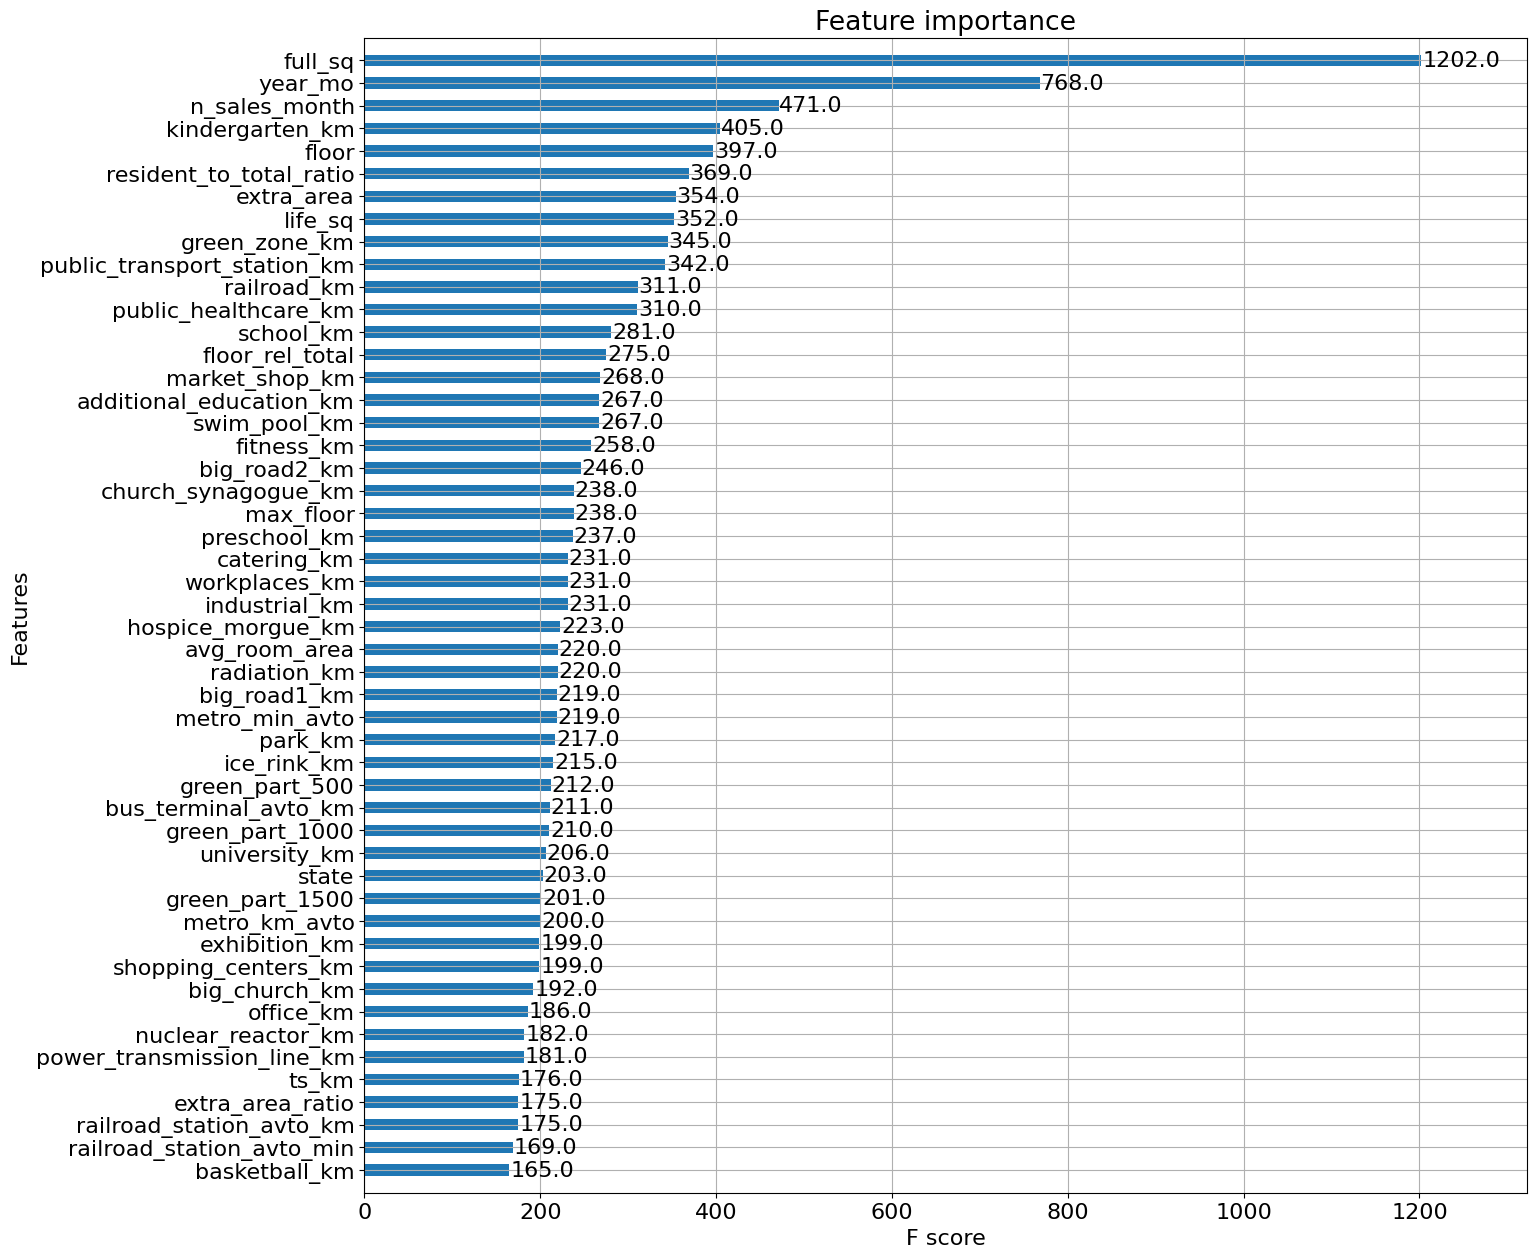

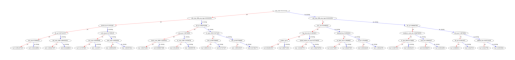

Training Data RMSE: 0.3856294706409704
This is the file exported XGBoost_20231101_180356.csv


In [ ]:
# Run model
naive_model, navie_dtrain, naive_dtest = XGBoost(xgb_cv_params, xTrain_naive, yTrain_naive, xTest_naive)
# Plot Feature Importance
plot_model(naive_model)
fit_model(naive_model, navie_dtrain, naive_dtest)
# Training Data RMSE: 0.3856294706409704
# Private Score: 0.33259
# Public Score: 0.32975

# XGBoost with top 50 Feature Selection but same parameters as naive XGB

Top Features ['full_sq', 'year_mo', 'floor', 'public_transport_station_km', 'kindergarten_km', 'n_sales_month', 'life_sq', 'resident_to_total_ratio', 'public_healthcare_km', 'green_zone_km', 'railroad_km', 'additional_education_km', 'extra_area', 'swim_pool_km', 'fitness_km', 'workplaces_km', 'school_km', 'radiation_km', 'catering_km', 'shopping_centers_km', 'bus_terminal_avto_km', 'preschool_km', 'church_synagogue_km', 'big_road2_km', 'market_shop_km', 'state', 'industrial_km', 'hospice_morgue_km', 'metro_km_avto', 'big_church_km', 'floor_rel_total', 'big_road1_km', 'metro_min_avto', 'green_part_500', 'green_part_1500', 'max_floor', 'ice_rink_km', 'exhibition_km', 'green_part_1000', 'park_km', 'ts_km', 'university_km', 'metro_min_walk', 'avg_room_area', 'basketball_km', 'trc_sqm_1500', 'water_treatment_km', 'office_km', 'thermal_power_plant_km', 'mosque_km']

In [ ]:
# Reduce overfitting by feature selection
# Choose the top 50 variables then reduce to 20 using DT
importance = naive_model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Get top 50 features
top_features_naive = [feature[0] for feature in sorted_importance[:50]]
print("Top Features", top_features_naive)

Top Features ['full_sq', 'year_mo', 'n_sales_month', 'kindergarten_km', 'floor', 'resident_to_total_ratio', 'extra_area', 'life_sq', 'green_zone_km', 'public_transport_station_km', 'railroad_km', 'public_healthcare_km', 'school_km', 'floor_rel_total', 'market_shop_km', 'swim_pool_km', 'additional_education_km', 'fitness_km', 'big_road2_km', 'max_floor', 'church_synagogue_km', 'preschool_km', 'industrial_km', 'workplaces_km', 'catering_km', 'hospice_morgue_km', 'radiation_km', 'avg_room_area', 'metro_min_avto', 'big_road1_km', 'park_km', 'ice_rink_km', 'green_part_500', 'bus_terminal_avto_km', 'green_part_1000', 'university_km', 'state', 'green_part_1500', 'metro_km_avto', 'shopping_centers_km', 'exhibition_km', 'big_church_km', 'office_km', 'nuclear_reactor_km', 'power_transmission_line_km', 'ts_km', 'railroad_station_avto_km', 'extra_area_ratio', 'railroad_station_avto_min', 'metro_min_walk']


In [ ]:
xTrain_feature1, yTrain_feature1 = xTrain.copy()[top_features_naive], yTrain.copy()
xTest_feature1 = xTest.copy()[top_features_naive]

[0]	train-rmse:0.60054+0.00118	test-rmse:0.60061+0.00840
[1]	train-rmse:0.59658+0.00117	test-rmse:0.59675+0.00831
[2]	train-rmse:0.59271+0.00114	test-rmse:0.59300+0.00828
[3]	train-rmse:0.58901+0.00113	test-rmse:0.58938+0.00822
[4]	train-rmse:0.58539+0.00112	test-rmse:0.58587+0.00817
[5]	train-rmse:0.58257+0.00110	test-rmse:0.58318+0.00813
[6]	train-rmse:0.57913+0.00110	test-rmse:0.57985+0.00806
[7]	train-rmse:0.57582+0.00108	test-rmse:0.57665+0.00802
[8]	train-rmse:0.57364+0.00107	test-rmse:0.57459+0.00807
[9]	train-rmse:0.57044+0.00105	test-rmse:0.57151+0.00800
[10]	train-rmse:0.56733+0.00105	test-rmse:0.56852+0.00796
[11]	train-rmse:0.56431+0.00104	test-rmse:0.56561+0.00793
[12]	train-rmse:0.56143+0.00105	test-rmse:0.56285+0.00789
[13]	train-rmse:0.55860+0.00106	test-rmse:0.56017+0.00786
[14]	train-rmse:0.55585+0.00106	test-rmse:0.55756+0.00781
[15]	train-rmse:0.55320+0.00104	test-rmse:0.55498+0.00781
[16]	train-rmse:0.55154+0.00109	test-rmse:0.55344+0.00774
[17]	train-rmse:0.55028+

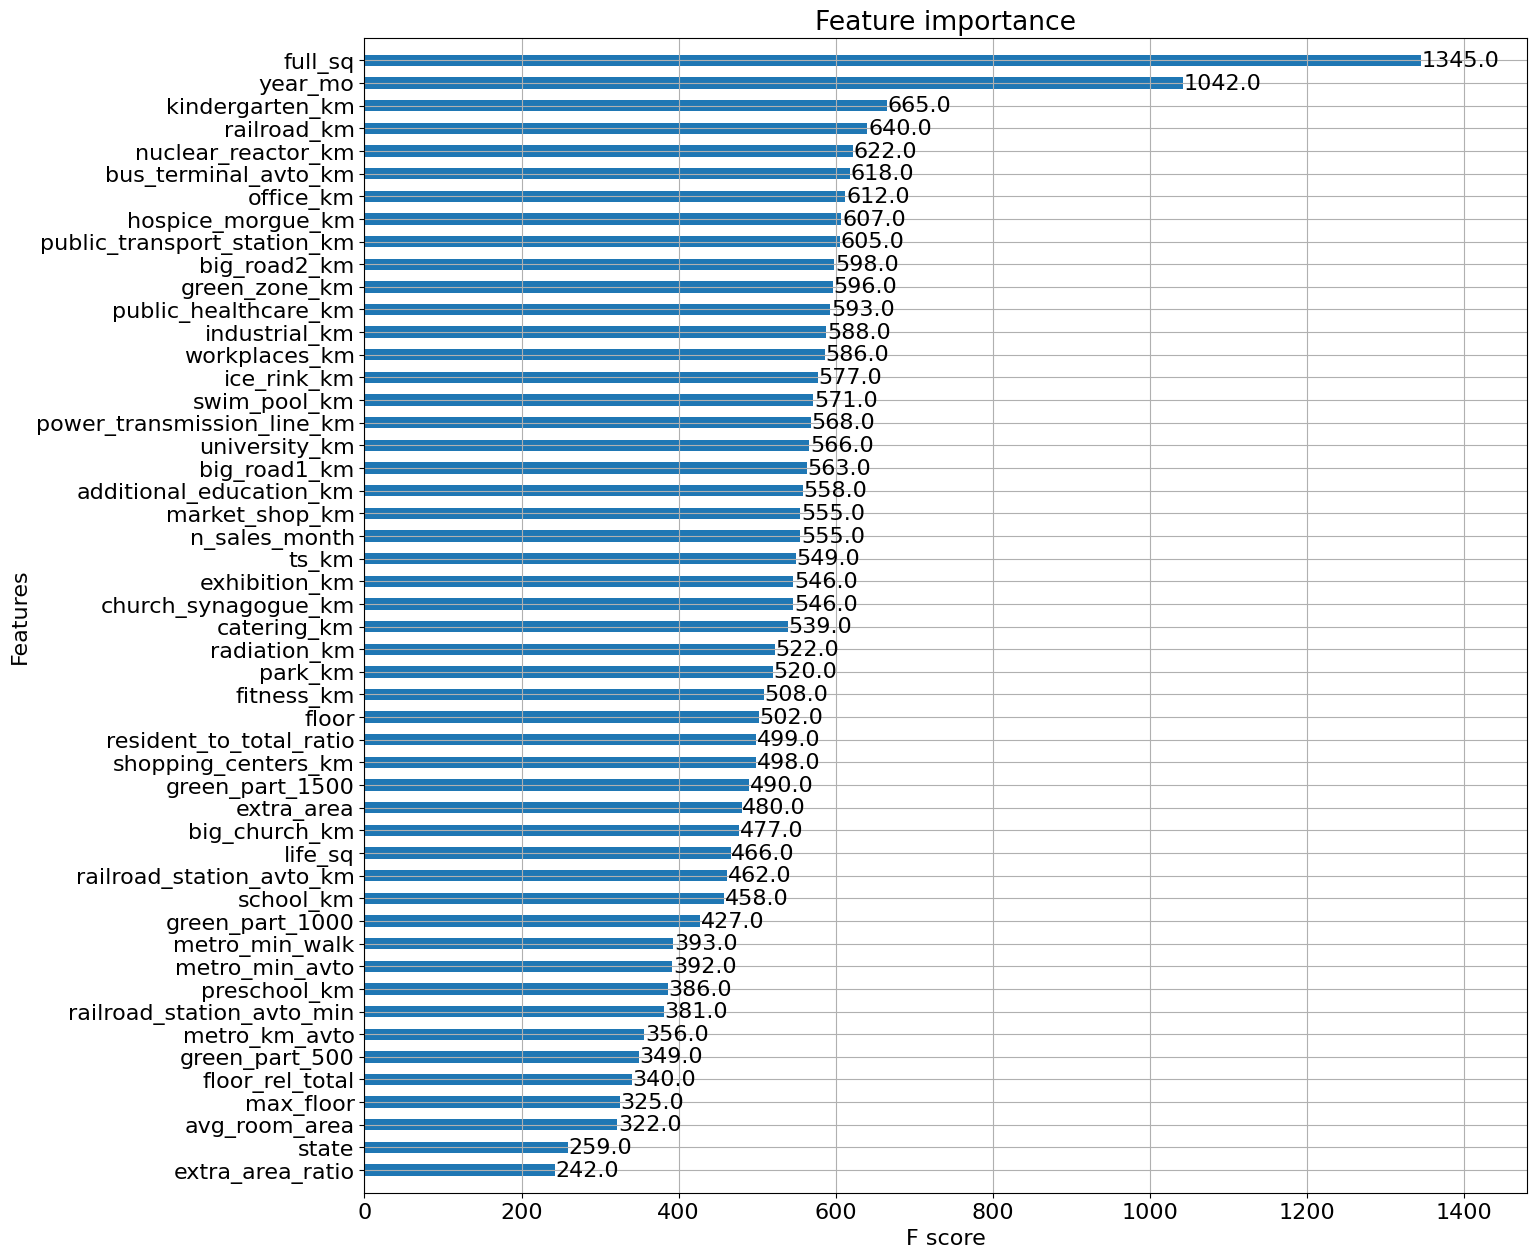

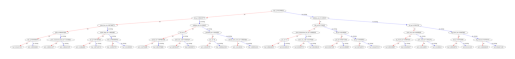

Training Data RMSE: 0.38832220820282687
This is the file exported XGBoost_20231101_180633.csv


In [ ]:
# Run model
feature_model1, feature_dtrain1, feature_dtest1 = XGBoost(xgb_cv_params, xTrain_feature1, yTrain_feature1, xTest_feature1)
# Plot Feature Importance
plot_model(feature_model1)
fit_model(feature_model1, feature_dtrain1, feature_dtest1)
# Training Data RMSE: 0.38832220820282687
# Private Score: 0.32616
# Public Score: 0.32489

# Feature Selection with 20 Best Params and Original XGBoost Parameters

In [ ]:
xTrain_feature_20, yTrain_feature_20 = xTrain.copy()[top_features_naive], yTrain.copy()
xTest_feature_20 = xTest.copy()[top_features_naive]

In [ ]:
# Try to further Reduce these features with RF selection
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, verbose = 2)
rf.fit(xTrain_feature_20, yTrain_feature_20)

# Get feature importance based on %IncMSE
rf_importance = rf.feature_importances_
sorted_idx = rf_importance.argsort()[::-1]

# Display the ranking of the top features
finalRes = []
for i, feature in enumerate(np.array(top_features_naive)[sorted_idx]):
    finalRes.append(feature)
    print(f"{i+1}. {feature}: {rf_importance[sorted_idx[i]]}")

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.3min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

In [ ]:
# Train XGBoost with top 20 features selected in RF Regressor
xTrain_feature_top20, yTrain_feature_top20 = xTrain.copy()[finalRes[:20]], yTrain.copy()
xTest_feature_top20 = xTest.copy()[finalRes[:20]]

[0]	train-rmse:0.60290+0.00122	test-rmse:0.60294+0.00849
[1]	train-rmse:0.60136+0.00124	test-rmse:0.60147+0.00848
[2]	train-rmse:0.59731+0.00122	test-rmse:0.59751+0.00840
[3]	train-rmse:0.59342+0.00120	test-rmse:0.59371+0.00831
[4]	train-rmse:0.58964+0.00118	test-rmse:0.59001+0.00824
[5]	train-rmse:0.58597+0.00117	test-rmse:0.58647+0.00819
[6]	train-rmse:0.58243+0.00116	test-rmse:0.58303+0.00812
[7]	train-rmse:0.57900+0.00114	test-rmse:0.57970+0.00808
[8]	train-rmse:0.57564+0.00114	test-rmse:0.57645+0.00799
[9]	train-rmse:0.57240+0.00112	test-rmse:0.57330+0.00793
[10]	train-rmse:0.56925+0.00111	test-rmse:0.57024+0.00788
[11]	train-rmse:0.56620+0.00110	test-rmse:0.56732+0.00784
[12]	train-rmse:0.56491+0.00112	test-rmse:0.56614+0.00786
[13]	train-rmse:0.56365+0.00112	test-rmse:0.56496+0.00790
[14]	train-rmse:0.56243+0.00111	test-rmse:0.56382+0.00792
[15]	train-rmse:0.56125+0.00112	test-rmse:0.56274+0.00795
[16]	train-rmse:0.55842+0.00112	test-rmse:0.55999+0.00792
[17]	train-rmse:0.55567+

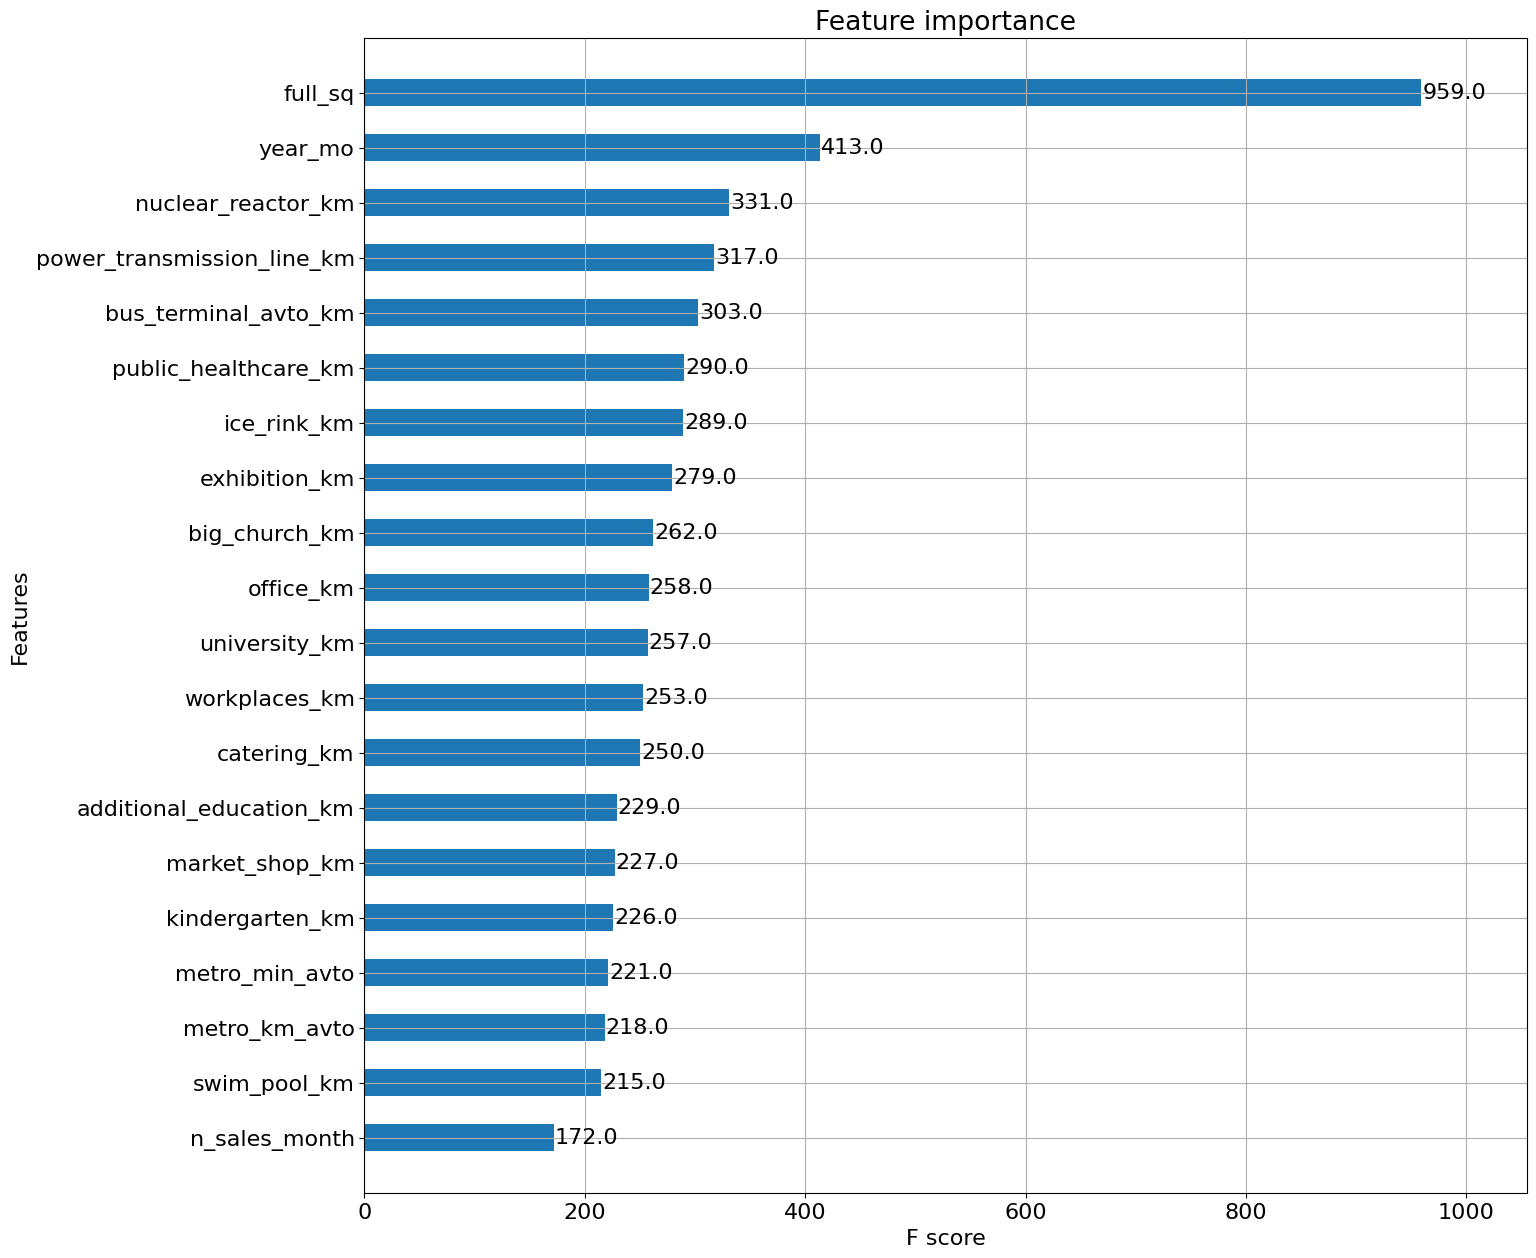

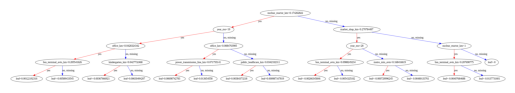

Training Data RMSE: 0.45328773571770786
This is the file exported XGBoost_20231101_181349.csv


In [ ]:
# Run model
feature_model_top20, feature_dtrain_top20, feature_dtest_top20 = XGBoost(xgb_cv_params, xTrain_feature_top20, yTrain_feature_top20, xTest_feature_top20)
# Plot Feature Importance
plot_model(feature_model_top20)
fit_model(feature_model_top20, feature_dtrain_top20, feature_dtest_top20)
# Reduction of features is useful but seems to be too much if we reduce by 20, 50 seems to be more ideal
# Private Score: 0.33095
# Public Score: 0.33026
# Training Data RMSE: 0.45328773571770786

# XGBoost Random Grid Seach with Top 50 Param - Train first, reduce features later

In [ ]:
xTrain_rd_search, yTrain_rd_search = xTrain.copy(), yTrain.copy()
xTest_rd_search = xTest.copy()

In [ ]:
# Hyperparameter distributions
xgb_param_dist = {
    'eta': uniform(0.01, 0.2),  # Continuous distribution from 0.01 to 0.21
    'max_depth': randint(3, 10),  # Discrete range from 3 to 9
    'subsample': uniform(0.5, 0.5),  # Continuous distribution from 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5),  # Continuous distribution from 0.5 to 1.0
    'min_child_weight': randint(1, 20),  # Discrete range from 1 to 19
    'gamma': uniform(0, 2),  # Continuous distribution from 0 to 2
    'alpha': uniform(0, 2),  # Continuous distribution from 0 to 2
    'lambda': uniform(0, 2)   # Continuous distribution from 0 to 2; for L2 regularization
}

# Setting up the random search
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', nthread=8, eval_metric='rmse'),
    param_distributions=xgb_param_dist,
    n_iter=50,  # number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    verbose=1,
    cv=5,  # 5-fold cross-validation
    random_state=42
)

# Performing the random search on the provided data
random_search.fit(xTrain_rd_search, yTrain_rd_search)

# Print best parameters
print("Best hyperparameters:")
random_params = random_search.best_params_
print(random_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters:
{'alpha': 0.8989013482764068, 'colsample_bytree': 0.5477050582452057, 'eta': 0.08416365043965326, 'gamma': 1.3376825053272146, 'lambda': 1.3318447132349933, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6373608964950321}


[0]	train-rmse:0.60120+0.00121	test-rmse:0.60125+0.00840
[1]	train-rmse:0.59703+0.00118	test-rmse:0.59721+0.00834
[2]	train-rmse:0.59297+0.00116	test-rmse:0.59326+0.00825
[3]	train-rmse:0.58908+0.00113	test-rmse:0.58949+0.00818
[4]	train-rmse:0.58529+0.00111	test-rmse:0.58582+0.00814
[5]	train-rmse:0.58224+0.00110	test-rmse:0.58288+0.00812
[6]	train-rmse:0.57865+0.00110	test-rmse:0.57943+0.00809
[7]	train-rmse:0.57516+0.00108	test-rmse:0.57606+0.00803
[8]	train-rmse:0.57243+0.00106	test-rmse:0.57342+0.00800
[9]	train-rmse:0.56971+0.00104	test-rmse:0.57081+0.00798
[10]	train-rmse:0.56647+0.00102	test-rmse:0.56770+0.00793
[11]	train-rmse:0.56332+0.00101	test-rmse:0.56469+0.00788
[12]	train-rmse:0.56029+0.00103	test-rmse:0.56178+0.00787
[13]	train-rmse:0.55793+0.00103	test-rmse:0.55954+0.00783
[14]	train-rmse:0.55562+0.00103	test-rmse:0.55733+0.00777
[15]	train-rmse:0.55332+0.00103	test-rmse:0.55515+0.00776
[16]	train-rmse:0.55058+0.00103	test-rmse:0.55253+0.00772
[17]	train-rmse:0.54847+

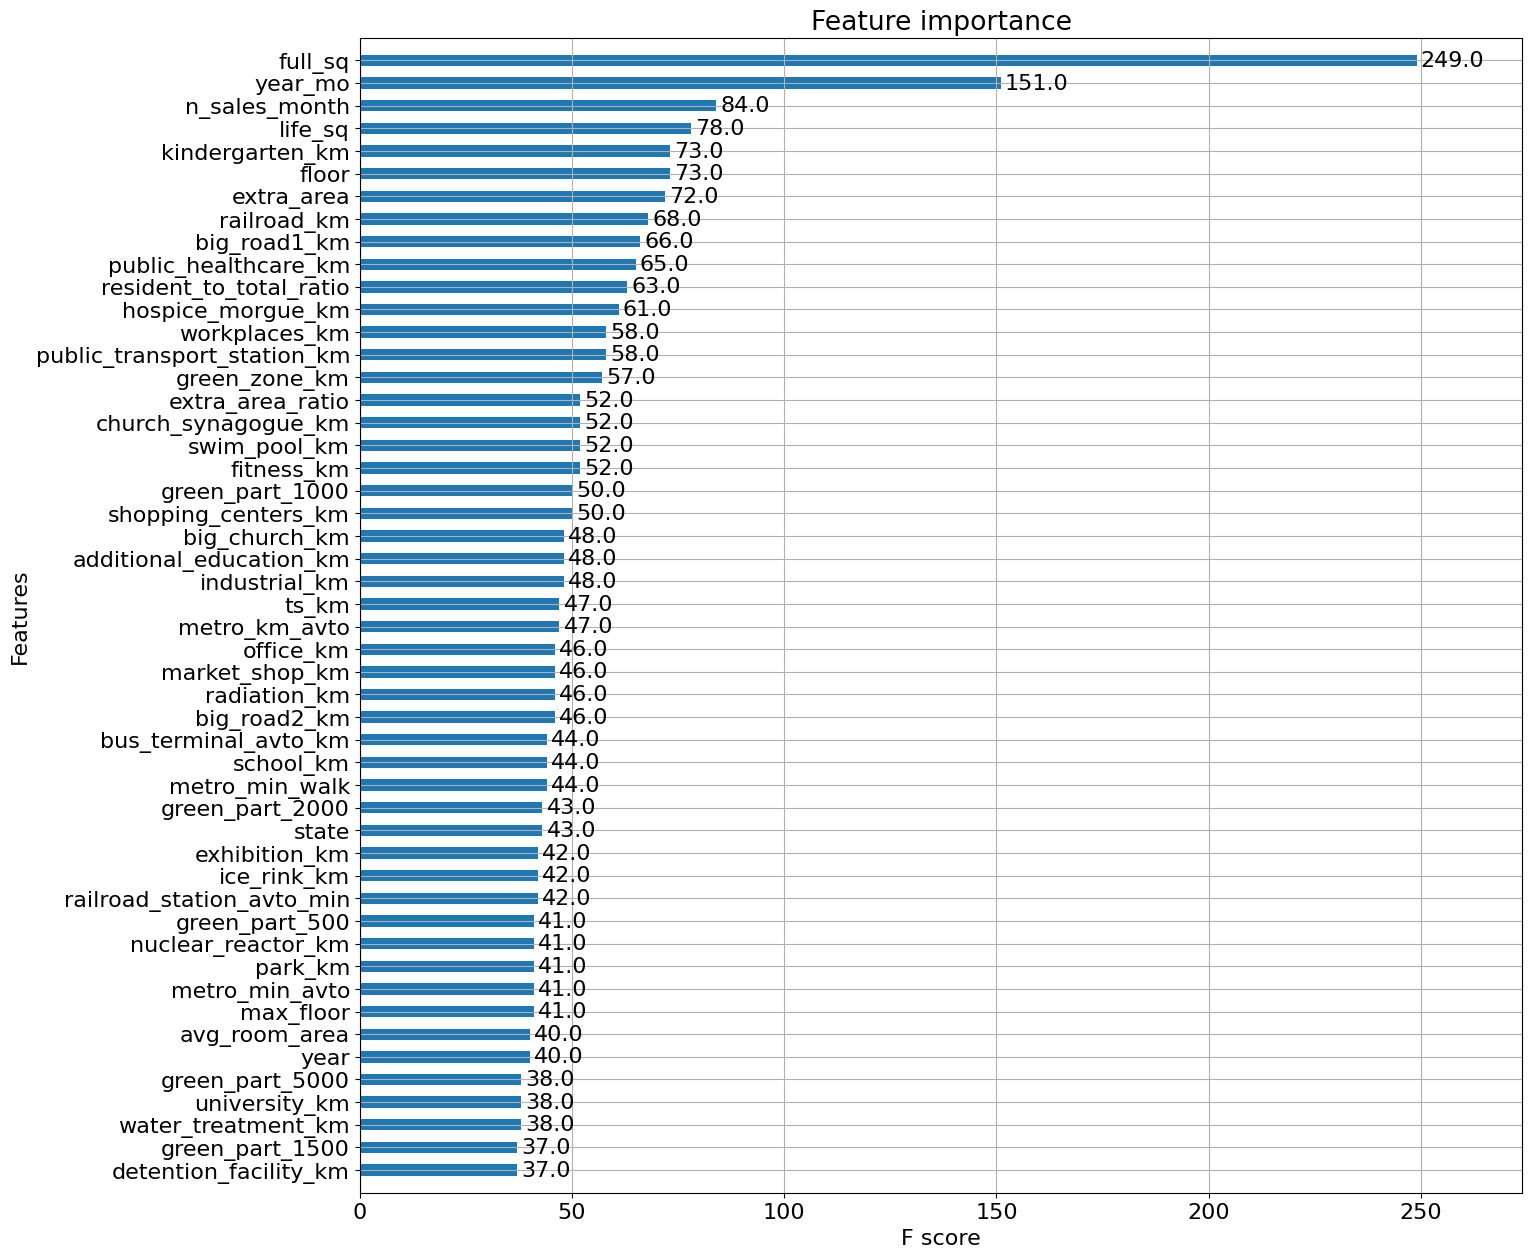

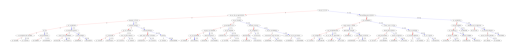

Training Data RMSE: 0.38614264561635714
This is the file exported XGBoost_20231101_184932.csv


In [ ]:
# Run model
#random_params = {'alpha': 0.8989013482764068, 'colsample_bytree': 0.5477050582452057, 'eta': 0.08416365043965326, 'gamma': 1.3376825053272146, 'lambda': 1.3318447132349933, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6373608964950321}
random_model, random_dtrain, random_dtest = XGBoost(random_params, xTrain_rd_search, yTrain_rd_search, xTest_rd_search)
# Plot Feature Importance
plot_model(random_model)
fit_model(random_model, random_dtrain, random_dtest)
# Training Data RMSE:0.38614264561635714
# Public: 0.33285
# Private: 0.33832

In [ ]:
# Reduce overfitting by feature selection
# Choose the top 50 variables then reduce to 20 using DT
importance = random_model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Get top 50 features
top_features_random = [feature[0] for feature in sorted_importance[:50]]
print("Top Features", top_features_random)

Top Features ['full_sq', 'year_mo', 'n_sales_month', 'life_sq', 'floor', 'kindergarten_km', 'extra_area', 'railroad_km', 'big_road1_km', 'public_healthcare_km', 'resident_to_total_ratio', 'hospice_morgue_km', 'public_transport_station_km', 'workplaces_km', 'green_zone_km', 'fitness_km', 'swim_pool_km', 'church_synagogue_km', 'extra_area_ratio', 'shopping_centers_km', 'green_part_1000', 'industrial_km', 'additional_education_km', 'big_church_km', 'metro_km_avto', 'ts_km', 'big_road2_km', 'radiation_km', 'market_shop_km', 'office_km', 'metro_min_walk', 'school_km', 'bus_terminal_avto_km', 'state', 'green_part_2000', 'railroad_station_avto_min', 'ice_rink_km', 'exhibition_km', 'max_floor', 'metro_min_avto', 'park_km', 'nuclear_reactor_km', 'green_part_500', 'year', 'avg_room_area', 'water_treatment_km', 'university_km', 'green_part_5000', 'detention_facility_km', 'green_part_1500']


In [ ]:
xTrain_rd_search_final, yTrain_rd_search_final = xTrain.copy()[top_features_random], yTrain.copy()
xTest_rd_search_final = xTest.copy()[top_features_random]

In [ ]:
# Hyperparameter distributions
xgb_param_dist = {
    'eta': uniform(0.01, 0.2),  # Continuous distribution from 0.01 to 0.21
    'max_depth': randint(3, 9),  # Discrete range from 3 to 9
    'subsample': uniform(0.5, 0.5),  # Continuous distribution from 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5),  # Continuous distribution from 0.5 to 1.0
    'min_child_weight': randint(1, 12),  # Discrete range from 1 to 19
    'gamma': uniform(1, 2),  # Continuous distribution from 0 to 2
    'alpha': uniform(1, 2),  # Continuous distribution from 0 to 2
    #'lambda': uniform(0, 2)   # Continuous distribution from 0 to 2; for L2 regularization
}

# Setting up the random search
final_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', nthread=8, eval_metric='rmse'),
    param_distributions=xgb_param_dist,
    n_iter=50,  # number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    verbose=1,
    cv=5,  # 5-fold cross-validation
    random_state=42
)

# Performing the random search on the provided data
final_search.fit(xTrain_rd_search_final, yTrain_rd_search_final)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b4045575900>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b4045576c80>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b40455751e0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b40455776d0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
print("Best hyperparameters:")
final_params = final_search.best_params_
print(final_params)

Best hyperparameters:
{'alpha': 1.8955663291461833, 'colsample_bytree': 0.776446544535664, 'eta': 0.12853934477587872, 'gamma': 1.1617066526654305, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8641081743059298}


In [ ]:
# Use XGBoost to perform cross validation
# Overfitting oberserved increase min_child_weight to 10
params = {
	'objective': 'reg:linear',
	'eval_metric': 'rmse',
	'eta': 0.12853934477587872,
	'alpha': 1.8955663291461833, 'colsample_bytree': 0.776446544535664, 'eta': 0.12853934477587872, 'gamma': 1.1617066526654305, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8641081743059298,
	"nthread": 8
}

[0]	train-rmse:0.60049+0.00118	test-rmse:0.60055+0.00840
[1]	train-rmse:0.59650+0.00117	test-rmse:0.59671+0.00831
[2]	train-rmse:0.59260+0.00115	test-rmse:0.59292+0.00822
[3]	train-rmse:0.58886+0.00115	test-rmse:0.58928+0.00816
[4]	train-rmse:0.58522+0.00113	test-rmse:0.58574+0.00811
[5]	train-rmse:0.58241+0.00111	test-rmse:0.58303+0.00808
[6]	train-rmse:0.57897+0.00110	test-rmse:0.57969+0.00805
[7]	train-rmse:0.57561+0.00108	test-rmse:0.57644+0.00800
[8]	train-rmse:0.57350+0.00108	test-rmse:0.57445+0.00802
[9]	train-rmse:0.57031+0.00107	test-rmse:0.57139+0.00793
[10]	train-rmse:0.56725+0.00105	test-rmse:0.56843+0.00789
[11]	train-rmse:0.56425+0.00104	test-rmse:0.56553+0.00786
[12]	train-rmse:0.56139+0.00106	test-rmse:0.56279+0.00782
[13]	train-rmse:0.55856+0.00105	test-rmse:0.56009+0.00781
[14]	train-rmse:0.55582+0.00105	test-rmse:0.55748+0.00778
[15]	train-rmse:0.55319+0.00105	test-rmse:0.55496+0.00777
[16]	train-rmse:0.55119+0.00103	test-rmse:0.55308+0.00779
[17]	train-rmse:0.54920+

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:57:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


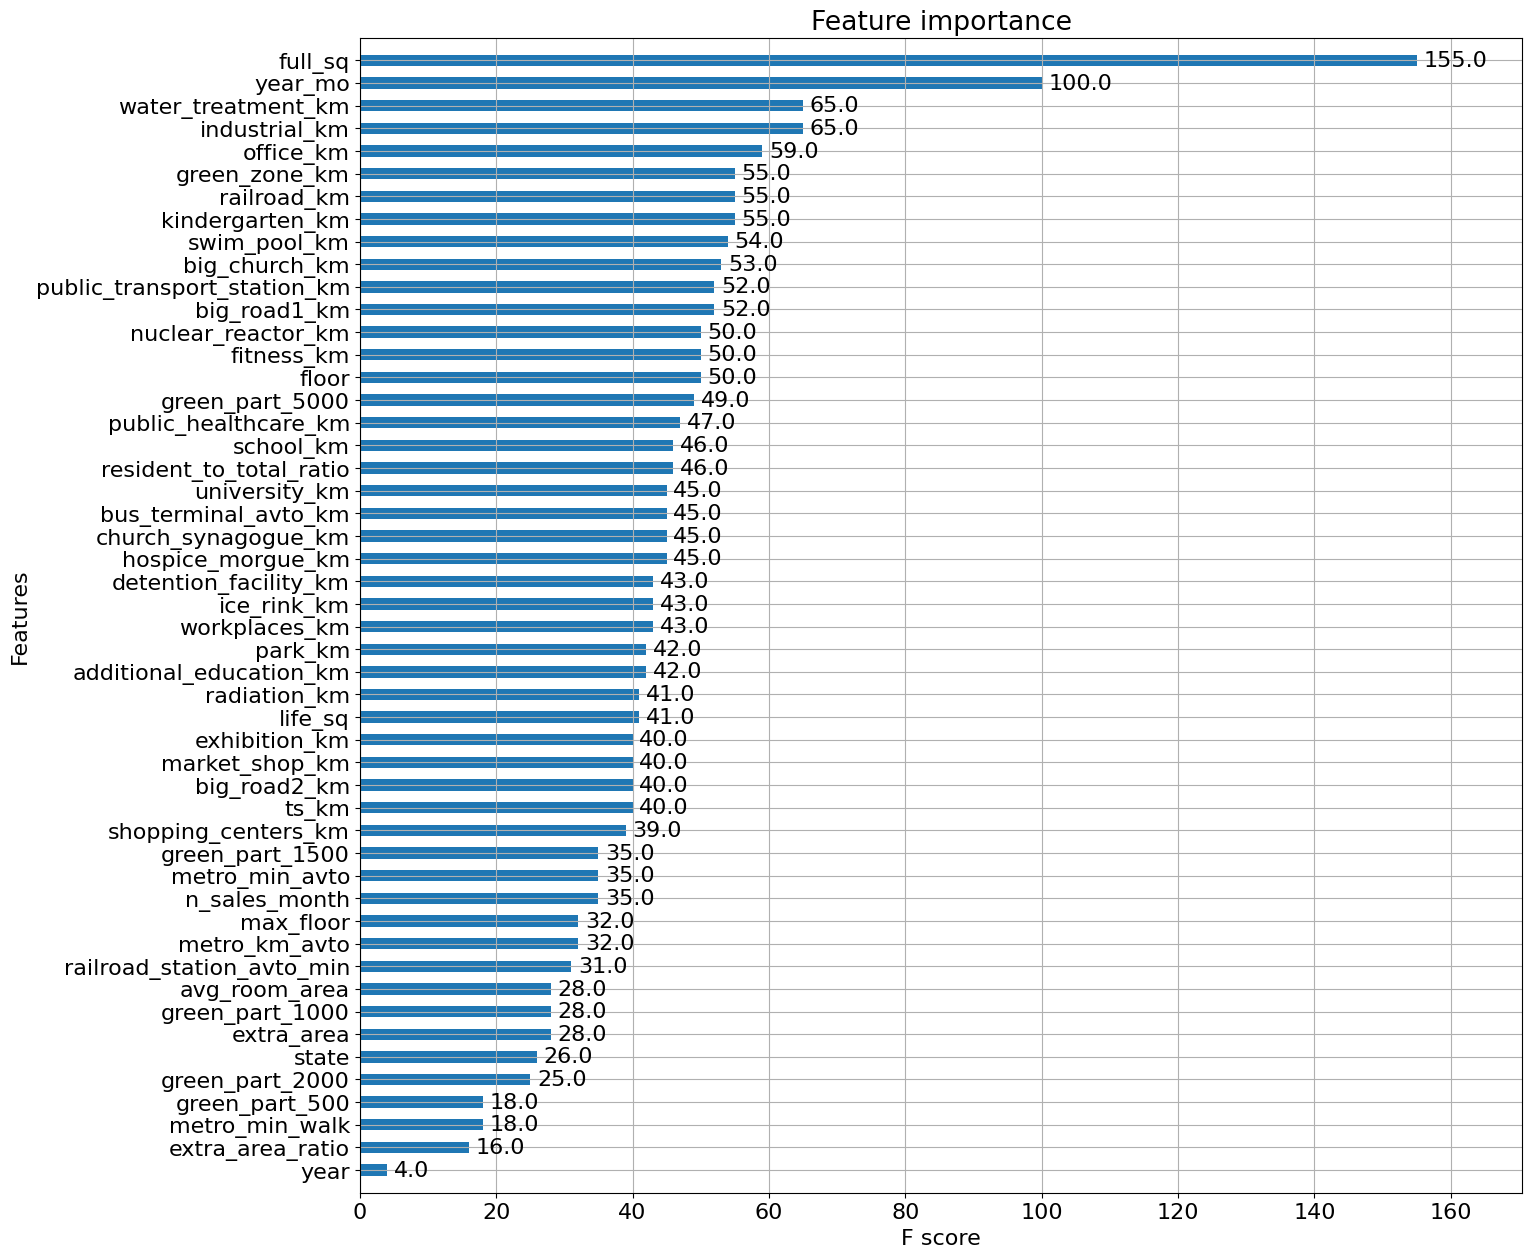

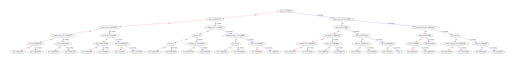

Training Data RMSE: 0.4189969890197487
This is the file exported XGBoost_20231101_185752.csv


In [ ]:
# Run model
final_model, final_dtrain, final_dtest = XGBoost(params, xTrain_rd_search_final, yTrain_rd_search_final, xTest_rd_search_final)
# Plot Feature Importance
plot_model(final_model)
fit_model(final_model, final_dtrain, final_dtest)
# Training Data RMSE: 0.4189969890197487
# Public: 0.3284
# Private: 0.3244

# Final Model: XGBoost Random Grid Search with top features from Naive Model then tune


In [ ]:
top_features_naive =  ['full_sq', 'year_mo', 'n_sales_month', 'kindergarten_km', 'floor', 'resident_to_total_ratio', 'extra_area', 'life_sq', 'green_zone_km', 'public_transport_station_km', 'railroad_km', 'public_healthcare_km', 'school_km', 'floor_rel_total', 'market_shop_km', 'swim_pool_km', 'additional_education_km', 'fitness_km', 'big_road2_km', 'max_floor', 'church_synagogue_km', 'preschool_km', 'industrial_km', 'workplaces_km', 'catering_km', 'hospice_morgue_km', 'radiation_km', 'avg_room_area', 'metro_min_avto', 'big_road1_km', 'park_km', 'ice_rink_km', 'green_part_500', 'bus_terminal_avto_km', 'green_part_1000', 'university_km', 'state', 'green_part_1500', 'metro_km_avto', 'shopping_centers_km', 'exhibition_km', 'big_church_km', 'office_km', 'nuclear_reactor_km', 'power_transmission_line_km', 'ts_km', 'railroad_station_avto_km', 'extra_area_ratio', 'railroad_station_avto_min', 'metro_min_walk']

In [ ]:
xTrain_rd_search_final2, yTrain_rd_search_final2 = xTrain.copy()[top_features_naive], yTrain.copy()
xTest_rd_search_final2 = xTest.copy()[top_features_naive]

In [ ]:
# Hyperparameter distributions
xgb_param_dist = {
    'eta': uniform(0.01, 0.2),  # Continuous distribution from 0.01 to 0.21
    'max_depth': randint(3, 9),  # Discrete range from 3 to 9
    'subsample': uniform(0.5, 0.5),  # Continuous distribution from 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5),  # Continuous distribution from 0.5 to 1.0
    'min_child_weight': randint(1, 12),  # Discrete range from 1 to 19
    'gamma': uniform(1, 2),  # Continuous distribution from 0 to 2
    'alpha': uniform(1, 2),  # Continuous distribution from 0 to 2
    #'lambda': uniform(0, 2)   # Continuous distribution from 0 to 2; for L2 regularization
}

# Setting up the random search
final_search2 = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', nthread=8, eval_metric='rmse'),
    param_distributions=xgb_param_dist,
    n_iter=50,  # number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    verbose=1,
    cv=5,  # 5-fold cross-validation
    random_state=42
)

# Performing the random search on the provided data
final_search2.fit(xTrain_rd_search_final2, yTrain_rd_search_final2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: ignored

In [ ]:
print("Best hyperparameters:")
final_params = final_search2.best_params_
print(final_params)

In [ ]:
# Suggested
final_params = { 'objective': 'reg:squarederror',  'eval_metric': 'rmse', 'alpha': 1.0461248500828315, 'colsample_bytree': 0.7623873301291946, 'eta': 0.02, 'gamma': 1.0933313264272309, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6912309956335814}

[0]	train-rmse:0.60030+0.00120	test-rmse:0.60045+0.00839
[1]	train-rmse:0.59611+0.00120	test-rmse:0.59645+0.00830
[2]	train-rmse:0.59204+0.00117	test-rmse:0.59255+0.00826
[3]	train-rmse:0.58811+0.00117	test-rmse:0.58883+0.00820
[4]	train-rmse:0.58428+0.00115	test-rmse:0.58515+0.00816
[5]	train-rmse:0.58118+0.00112	test-rmse:0.58224+0.00812
[6]	train-rmse:0.57754+0.00113	test-rmse:0.57883+0.00807
[7]	train-rmse:0.57402+0.00111	test-rmse:0.57550+0.00804
[8]	train-rmse:0.57158+0.00107	test-rmse:0.57326+0.00809
[9]	train-rmse:0.56819+0.00106	test-rmse:0.57009+0.00803
[10]	train-rmse:0.56488+0.00105	test-rmse:0.56698+0.00800
[11]	train-rmse:0.56167+0.00103	test-rmse:0.56399+0.00798
[12]	train-rmse:0.55859+0.00106	test-rmse:0.56108+0.00793
[13]	train-rmse:0.55559+0.00107	test-rmse:0.55832+0.00788
[14]	train-rmse:0.55264+0.00107	test-rmse:0.55560+0.00785
[15]	train-rmse:0.54978+0.00105	test-rmse:0.55294+0.00784
[16]	train-rmse:0.54783+0.00106	test-rmse:0.55119+0.00783
[17]	train-rmse:0.54513+

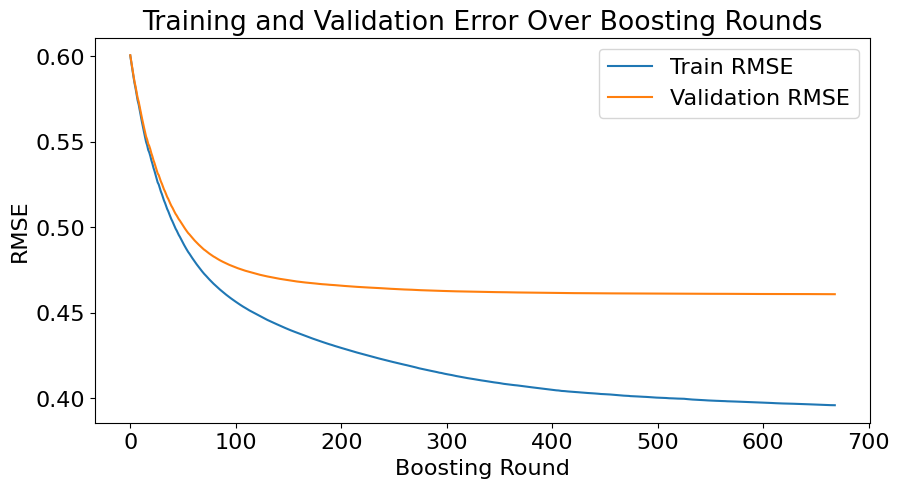

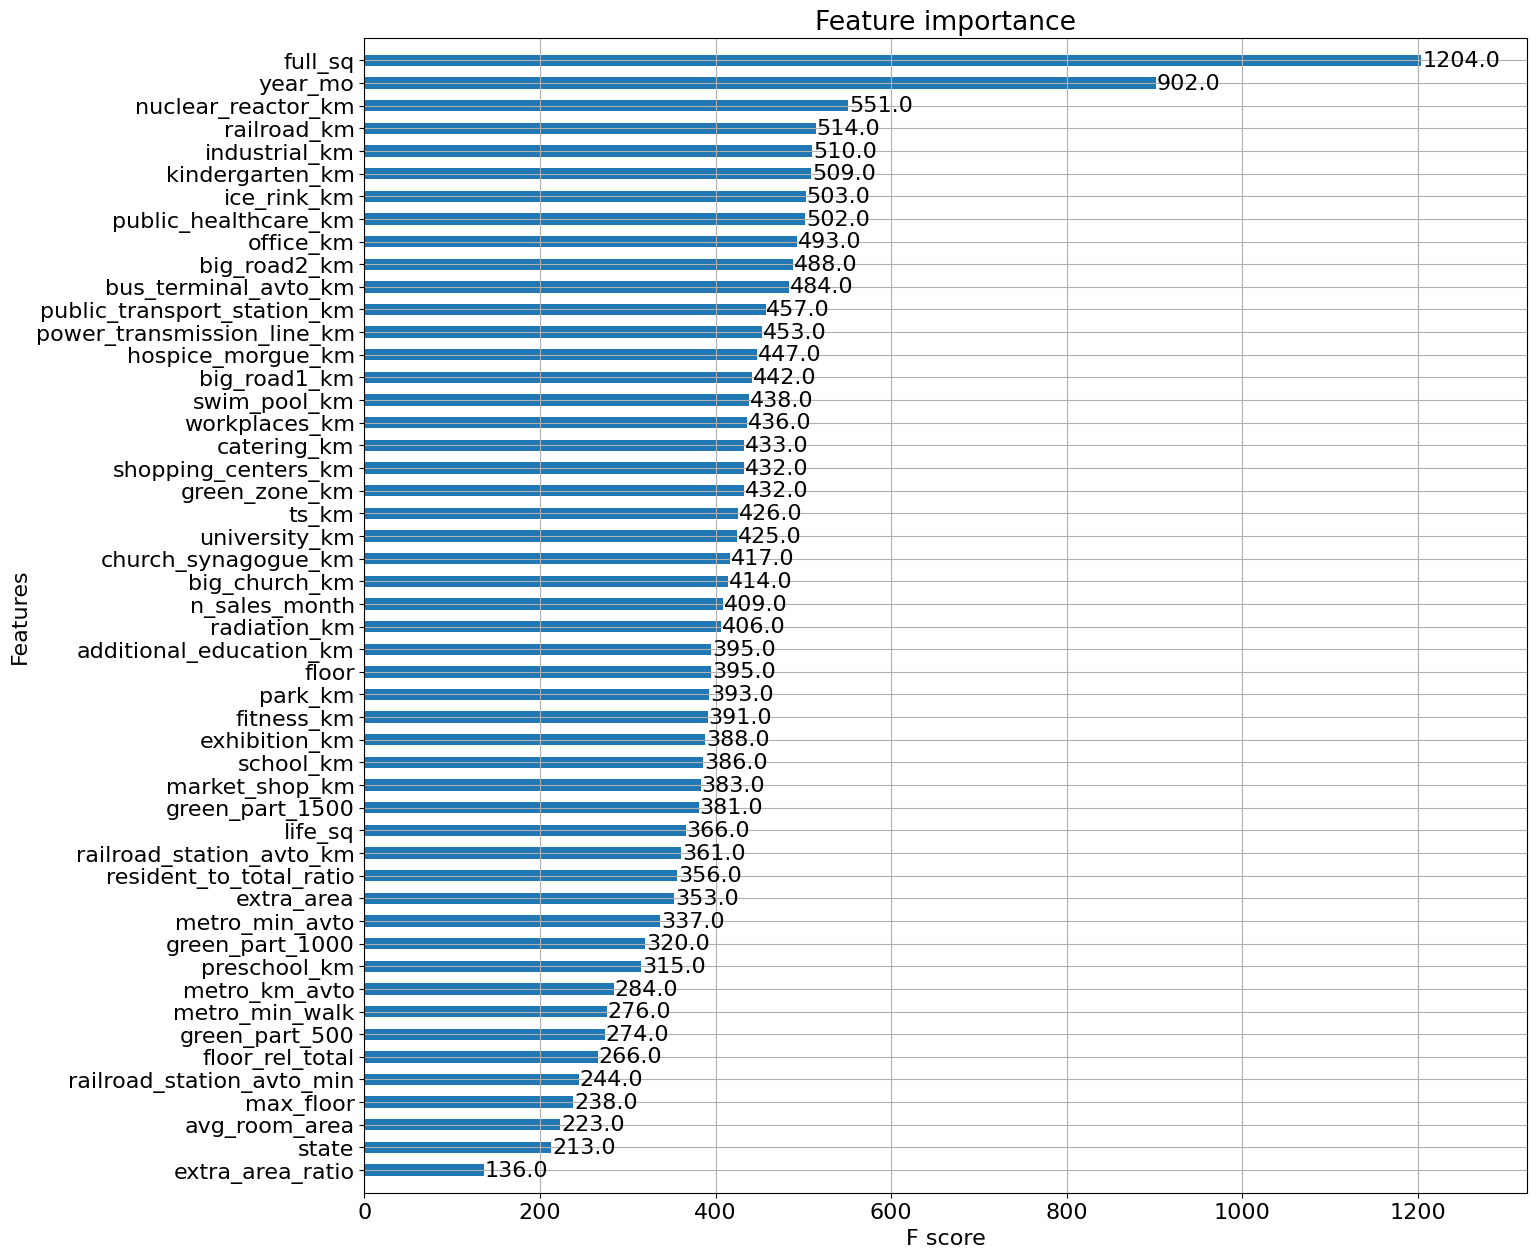

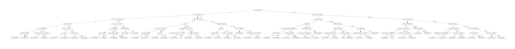

Training Data RMSE: 0.3931366708618458
This is the file exported XGBoost_20231107_084739.csv


In [ ]:
# Run model
final_model2, final_dtrain2, final_dtest2 = XGBoost(final_params, xTrain_rd_search_final2, yTrain_rd_search_final2, xTest_rd_search_final2)
# Plot Feature Importance
plot_model(final_model2)
fit_model(final_model2, final_dtrain2, final_dtest2)
# Public: 0.32469
# Private: 0.32603

# Final Model: Using Kaggle's Magic Number
Cross validation to check train and test RMSE

In [16]:
path = '/content/drive/MyDrive/NTU/CS/CZ4041/'
# path = '/content/drive/MyDrive/NTU/Courses/CZ4041/'
xTrain=pd.read_csv(path + 'cleaned_train_2.csv')
xTest=pd.read_csv(path + 'cleaned_test_2.csv')
# xTrain=pd.read_csv(path + 'cleaned_train.csv')
# xTest=pd.read_csv(path + 'cleaned_test.csv')

In [17]:
xTrain=xTrain[(xTrain.price_doc>1e6) & (xTrain.price_doc!=2e6) & (xTrain.price_doc!=3e6)]
xTrain.loc[(xTrain.product_type=='Investment') & (xTrain.build_year<2000),'price_doc']*=0.895
xTrain.loc[xTrain.product_type!='Investment','price_doc']*=0.96

In [18]:
yTrain = xTrain['price_doc'].apply(lambda x: np.log1p(x))
xTrain.drop(columns=['id','timestamp','price_doc'],axis=1,inplace=True)

print(xTrain.shape)

(28402, 279)


In [19]:
#Split train data into 2 parts
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(xTrain, yTrain, test_size=0.15,random_state=42)

In [20]:
from sklearn import preprocessing

numerical_cols = xTrain.select_dtypes(exclude=['object'])
categorical_cols = xTrain.select_dtypes(include=['object']).copy()

# Encoding for categorical columns:
for c in categorical_cols:
  le = preprocessing.LabelEncoder()
  le.fit(X_tr[c])

  X_val[c] = X_val[c].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  le.classes_ = np.append(le.classes_, '<unknown>')

  X_tr[c] = le.transform(X_tr[c])
  X_val[c] = le.transform(X_val[c])

# Scaling for numercial columns:
for c in numerical_cols:
  min = X_tr[c].min()
  max = X_tr[c].max()

  X_tr[c] = (X_tr[c] - min)/(max-min)
  X_val[c] = (X_val[c] - min)/(max-min)

In [21]:
testID = xTest['id']
xTest.drop(['id', 'timestamp'],axis=1,inplace=True)

print(xTest.shape)

(7662, 279)


In [23]:
num = xTrain.select_dtypes(exclude=['object'])
cat = xTrain.select_dtypes(include=['object']).copy()


for c in cat:
  le = preprocessing.LabelEncoder()
  le.fit(xTrain[c])

  xTest[c] = xTest[c].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  le.classes_ = np.append(le.classes_, '<unknown>')

  xTest[c] = le.transform(xTest[c])

for c in num:
  min = xTrain[c].min()
  max = xTrain[c].max()

  xTest[c] = (xTest[c] - min)/(max-min)

In [ ]:
# Try Hyperparameter Tuning
# Hyperparameter distributions
xgb_param_dist = {
    'eta': uniform(0.01, 0.2),  # Continuous distribution from 0.01 to 0.21
    'max_depth': randint(3, 9),  # Discrete range from 3 to 9
    'subsample': uniform(0.5, 0.5),  # Continuous distribution from 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5),  # Continuous distribution from 0.5 to 1.0
    'min_child_weight': randint(1, 12),  # Discrete range from 1 to 19
    'gamma': uniform(1, 2),  # Continuous distribution from 0 to 2
    'alpha': uniform(1, 2),  # Continuous distribution from 0 to 2
    #'lambda': uniform(0, 2)   # Continuous distribution from 0 to 2; for L2 regularization
}

# Setting up the random search
final_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', nthread=8, eval_metric='rmse'),
    param_distributions=xgb_param_dist,
    n_iter=50,  # number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    verbose=1,
    cv=5,  # 5-fold cross-validation
    random_state=42
)

# Performing the random search on the provided data
final_search.fit(X_tr, y_tr)

In [ ]:
print("Best hyperparameters:")
final_params = final_search.best_params_
print(final_params)

In [24]:
final_params = {'alpha': 1.0461248500828315, 'colsample_bytree': 0.7623873301291946, 'eta': 0.08997219434305109, 'gamma': 1.0933313264272309, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6912309956335814}

[0]	train-rmse:0.44806+0.00130	test-rmse:0.44857+0.00921
[1]	train-rmse:0.42430+0.00120	test-rmse:0.42515+0.00942
[2]	train-rmse:0.40322+0.00119	test-rmse:0.40469+0.00956
[3]	train-rmse:0.38687+0.00133	test-rmse:0.38904+0.00971
[4]	train-rmse:0.37238+0.00130	test-rmse:0.37526+0.01009
[5]	train-rmse:0.35718+0.00132	test-rmse:0.36076+0.01020
[6]	train-rmse:0.34391+0.00135	test-rmse:0.34798+0.01046
[7]	train-rmse:0.33361+0.00130	test-rmse:0.33839+0.01072
[8]	train-rmse:0.32478+0.00131	test-rmse:0.33027+0.01105
[9]	train-rmse:0.31528+0.00139	test-rmse:0.32143+0.01123
[10]	train-rmse:0.30863+0.00146	test-rmse:0.31542+0.01147
[11]	train-rmse:0.30106+0.00157	test-rmse:0.30844+0.01154
[12]	train-rmse:0.29428+0.00162	test-rmse:0.30226+0.01168
[13]	train-rmse:0.28840+0.00167	test-rmse:0.29702+0.01181
[14]	train-rmse:0.28322+0.00169	test-rmse:0.29241+0.01192
[15]	train-rmse:0.27866+0.00173	test-rmse:0.28840+0.01207
[16]	train-rmse:0.27471+0.00176	test-rmse:0.28492+0.01218
[17]	train-rmse:0.27171+

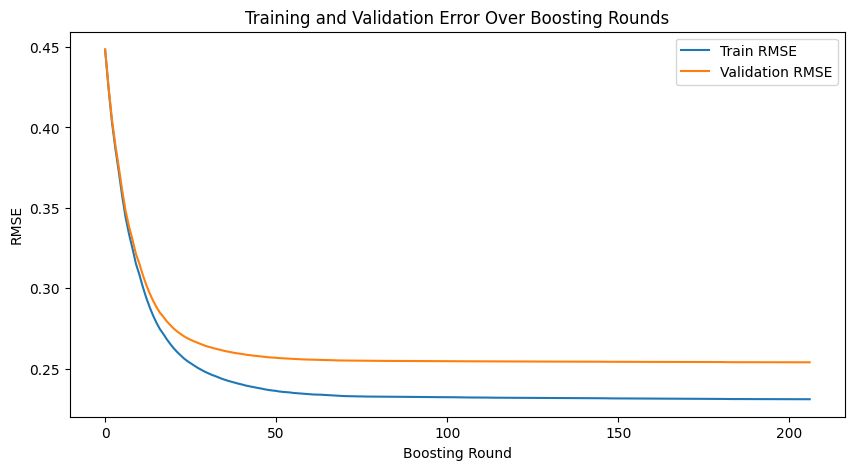

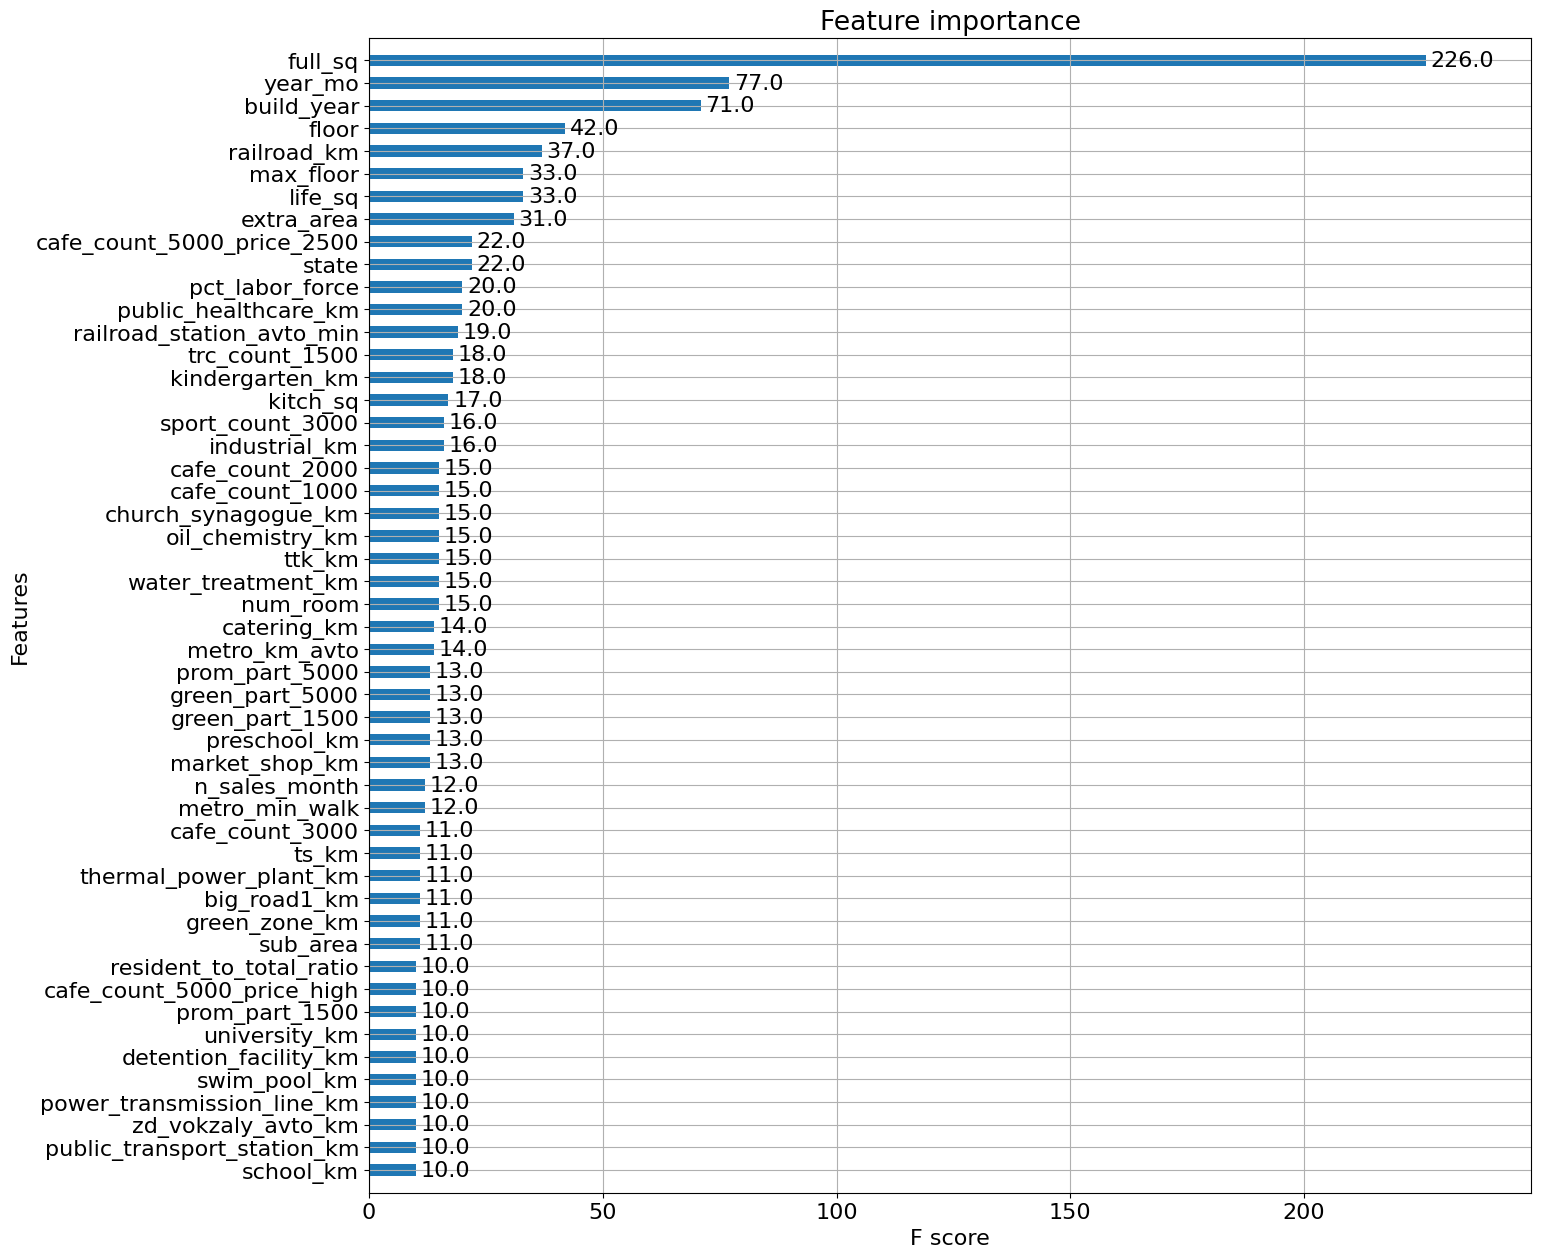

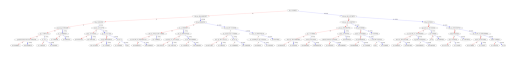

Training Data RMSE: 0.22906620324763924
This is the file exported XGBoost_20231123_161531.csv


In [25]:
# Run model
model, dtrain, dtest = XGBoost(final_params,  X_tr.copy(), y_tr, xTest, 20) # Lower Early stopping rounds to reduce overfit
# Plot Feature Importance
plot_model(model)
fit_model(model, dtrain, dtest, y_tr)
# Public: 0.31746
# Private: 0.31854

In [26]:
# Export Model
# File path where you want to save the pickle file
file_path = 'XGBoost.pkl'

# Writing the model details to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model, file)

In [27]:
# predict on cross validation data
yPred = model.predict(xgb.DMatrix(X_val))
mse = mean_squared_error(y_val, yPred)
print("Predict Cross Validation")
print("MSE : %.4f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))

Predict Cross Validation
MSE : 0.0629
RMSE: 0.2507
